In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

tune_result_dir = "tuning_results/ocar/tuning_results_ocar_ETTh2_pl24_olfull_optadam_tb1_2025_06_13_02_43_608f.csv"
sigma = 0.3
param1 = "config/OCAR_alpha_ema"
param2 = "config/OCAR_regul"
metric_name = "mse"

mse                                    3.655835
timestamp                            1749783544
checkpoint_dir_name                         NaN
done                                      False
training_iteration                            1
trial_id                               995b8f12
date                        2025-06-13_04-59-04
time_this_iter_s                     819.512507
time_total_s                         819.512507
pid                                       78079
hostname                    dl580-gpu3.unipi.it
node_ip                           131.114.142.6
time_since_restore                   819.512507
iterations_since_restore                      1
config/online_lr                        0.02852
config/OCAR_regul                        0.1131
config/OCAR_alpha_ema                  0.542537
logdir                                 995b8f12
Name: 54, dtype: object


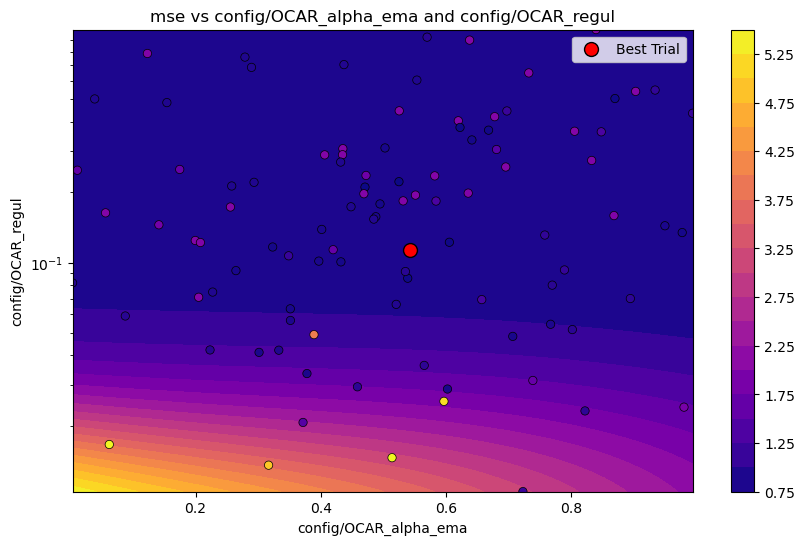

In [ ]:
log_list = ["config/online_lr", "config/OCAR_regul", "config/OCAR_regul_last"]

# Load the csv
df = pd.read_csv(tune_result_dir)
#drop nans
df = df.dropna(subset=[param1, param2, metric_name])

#Drop all the row with metric equal to 1e10
#df = df[df[metric_name] != 1e10]

# Extract relevant data
x = df[param1].values

z = df[metric_name].values

# Check if param1 and param2 are in log scale
is_param1_log = param1 in log_list
x_log = np.log10(x) if is_param1_log else x

# Check if param2 exists in the DataFrame
if param2 is not None:
    y = df[param2].values
    is_param2_log = param2 in log_list
    y_log = np.log10(y) if is_param2_log else y
    
    # Create grid data for contour plot
    xi = np.linspace(x_log.min(), x_log.max(), 100)
    yi = np.linspace(y_log.min(), y_log.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    
    # Define a Gaussian kernel function
    def gaussian_kernel(d, sigma=sigma):
        return np.exp(-0.5 * (d / sigma) ** 2)
    
    # Compute the weighted average at each grid point
    zi = np.zeros_like(xi)
    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            distances = np.sqrt((xi[i, j] - x_log) ** 2 + (yi[i, j] - y_log) ** 2)
            weights = gaussian_kernel(distances)
            zi[i, j] = np.sum(weights * z) / np.sum(weights)

    
    
    # Create the contour plot with log scale for both axes
    plt.figure(figsize=(10, 6))
    contour = plt.contourf(10**xi if is_param1_log else xi, 10**yi if is_param2_log else yi, zi, levels=20, cmap='plasma')
    plt.colorbar(contour)
    plt.scatter(x, y, c=z, edgecolors='k', linewidths=0.5, cmap='plasma', norm=matplotlib.colors.LogNorm())
    if is_param1_log:
        plt.xscale('log')
    if is_param2_log:
        plt.yscale('log')
    plt.xlabel(param1)
    plt.ylabel(param2)
    
    # Find the best trial and highlight it on the plot
    best_config = df.loc[df[metric_name].idxmin()]
    print(best_config)
    # Highlight the best trial
    best_x = best_config[param1]
    best_y = best_config[param2]
    best_z = best_config[metric_name]
    plt.scatter(best_x, best_y, color='red', s=100, edgecolors='k', linewidths=1, label='Best Trial')
    

    
else:
    # Create grid data for line plot
    xi = np.linspace(x_log.min(), x_log.max(), 100)
    
    # Define a Gaussian kernel function
    def gaussian_kernel(d, sigma=sigma):
        return np.exp(-0.5 * (d / sigma) ** 2)
    
    # Compute the weighted average at each grid point
    zi = np.zeros_like(xi)
    for i in range(xi.shape[0]):
        distances = np.abs(xi[i] - x_log)
        weights = gaussian_kernel(distances)
        zi[i] = np.sum(weights * z) / np.sum(weights)
    
    # Create the line plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x, z, edgecolors='k', linewidths=0.5, label='Data', cmap='plasma')
    plt.plot(10**xi if is_param1_log else xi, zi, label='Weighted Average', color='red')
    if is_param1_log:
        plt.xscale('log')
    plt.xlabel(param1)
    plt.ylabel(metric_name)

    
    # Find the best trial and highlight it on the plot
    best_config = df.loc[df[metric_name].idxmin()]
    print(best_config)
    # Highlight the best trial
    best_x = best_config[param1]
    best_z = best_config[metric_name]
    plt.scatter(best_x, best_z, color='red', s=100, edgecolors='k', linewidths=1, label='Best Trial')
    

# Finalize the plot
plt.title(f'{metric_name} vs {param1}' + (f' and {param2}' if param2 else ''))
plt.legend()

plt.show()
